# Engineering Colleges Case Study.
- Education is fast becoming a very competitive sector with hundreds of institutions to choose from. It is a life transforming experience for any student and it has to be a thoughtful decision. There are ranking agencies which do a survey of all the colleges to provide more insights to students and to identify different types of engineering colleges in the country to better understand the state of affairs. 

## My aim is to
- How many different types (clusters/segments) of colleges can be found from the data?
- How are these different types of colleges different from each other? Provide a profile summary of the clusters/segments, provide insights and make business recommendations.

**About the Dataset**

The data is for 26 EngineeringColleges. The initial survey data has been summarized into a rating scale of 1-5 for different factors.

**Factor rating index**
 - 1 - Very low
 - 2 - Low
 - 3 - Medium
 - 4 - High
 - 5 - Very high
 
 
**Data Dictionary**
 - SR_NO : Serial Number
 - Engg_College : 26 Engineering colleges with pseudonyms A to Z
 - Teaching : Quality of teaching at the engineering college
 - Fees : Fees at the engineering college
 - Placements : Job placements after a student graduates from the engineering college
 - Internship : Student Internships at the engineering college
 - Infrastructure : Infrastructure of the engineering college

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from kneed import KneeLocator # to locate the elbow point of the curve

from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [3]:
# Reading the dataset 
data=pd.read_excel('Engineering Colleges.xlsx')

In [4]:
# make a copy of the data.

df=data.copy()

In [5]:
# view the data

df.head()

,SR_NO,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
0,1,A,5,2,5,5,3
1,2,B,4,2,5,5,3
2,3,C,4,5,5,4,5
3,4,D,5,4,5,4,4
4,5,E,2,5,2,2,5


In [6]:
#dropping the serial no. column as it does not hold any statistical significance

df.drop('SR_NO',axis=1,inplace=True)

In [7]:
# data information check

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Internship      26 non-null     int64 
 5   Infrastructure  26 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


**Observations**
- We have 26 rows and 6 columns in the data
- Engg_College is a categorical variable with 26 levels which indicate each college names
- The 5 rating variables are of type 'integer'

In [8]:
#summarize numerical column

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Teaching,26.00,2.81,1.13,1.00,2.00,3.00,3.00,5.00
Fees,26.00,3.58,1.33,1.00,2.25,4.00,5.00,5.00
Placements,26.00,2.88,1.53,1.00,1.25,3.00,4.00,5.00
Internship,26.00,2.77,1.24,1.00,2.00,2.00,4.00,5.00
Infrastructure,26.00,3.38,1.30,1.00,3.00,3.00,4.75,5.00


**Observations**
- Median of Fees is 4 indicating most of the engineering colleges have high fees
- The mean and median of other ratings lie in 2-3 as expected 


In [9]:
# check for missing values.

df.isnull().sum()

Engg_College      0
Teaching          0
Fees              0
Placements        0
Internship        0
Infrastructure    0
dtype: int64

There are no missing values in our data

# EDA

### Univariate Analysis

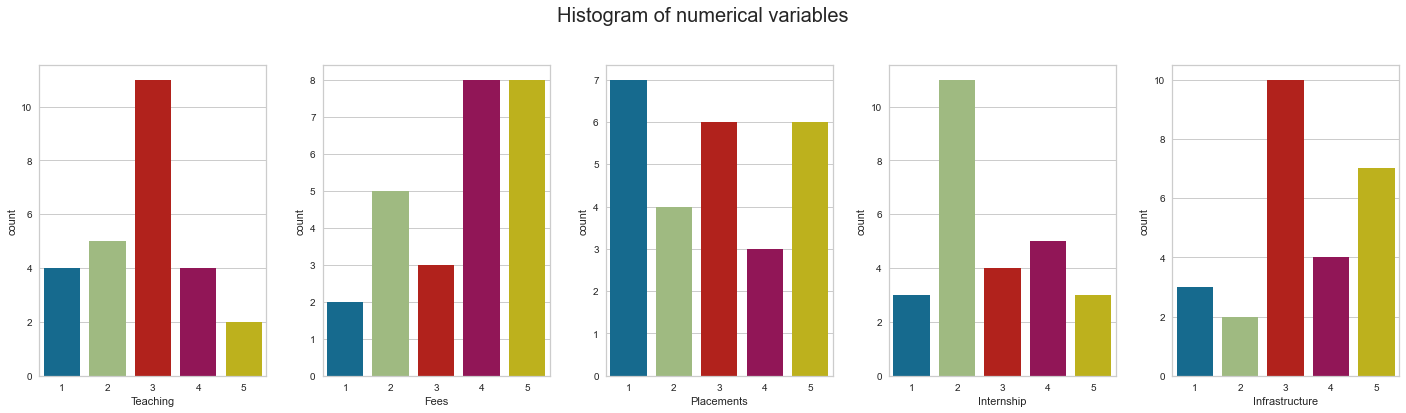

In [10]:
#check the frequency of each columns.

all_col = df.iloc[:,1:].columns.tolist() # assigning all numerical column to a variable
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.countplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Observations**
- Most of the colleges have got 3 as rating for teaching
- Fees in most of the colleges high
- Most of the colleges have 2 as rating for placements

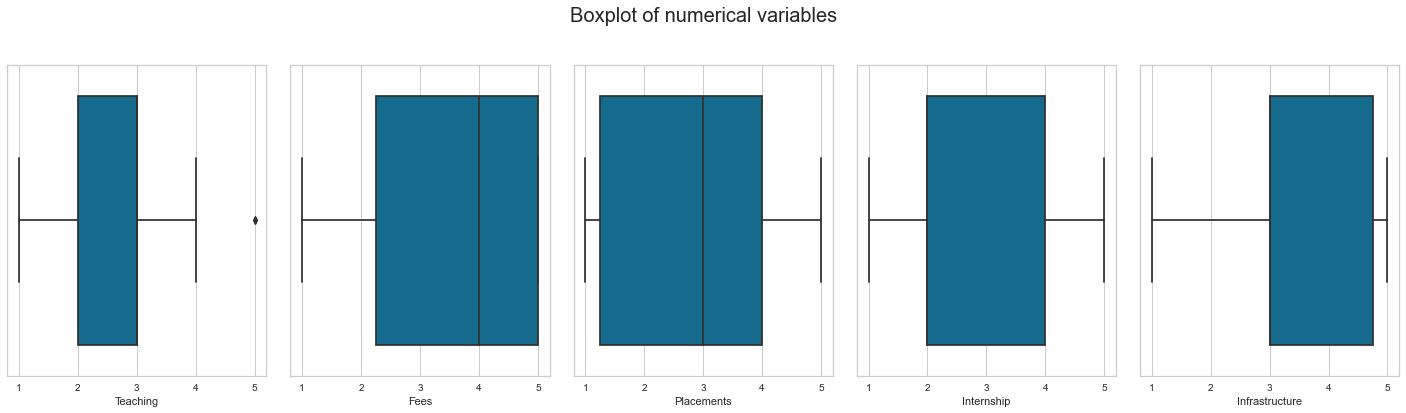

In [11]:
#check the distribution of the data using box plot.

fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],x=df[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Observations**
- 50 % of colleges have rating off 2 and 3
- 50 % of colleges have fees high or very high
- 75 % of colleges have rating less than 4 in placements
- 75 % of colleges have 3 more rating in infrastructure

### Bivariate Analsysis

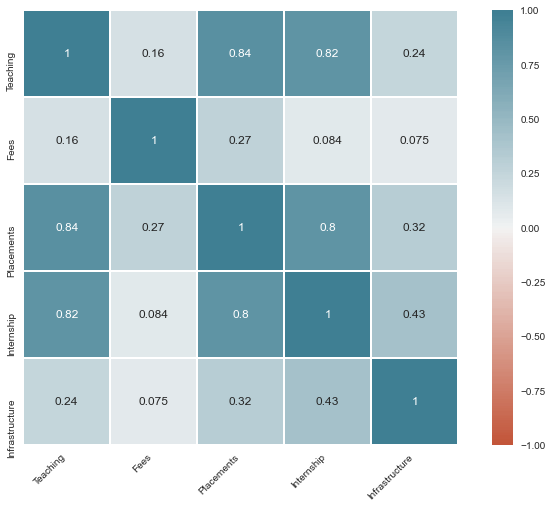

In [12]:
# Apply correlation plot to see the correlation between numerical variables.

plt.figure(figsize=(12,8))
corr = df.corr()
ax = sns.heatmap(df.dropna().corr(), vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200),
                 linecolor='white', linewidths=2, annot = True,square=True)
ax.set_xticklabels( ax.get_xticklabels(), rotation=45, horizontalalignment='right');

**Observation**
- Teaching is strongly positively correlated with Placement and internships, which is obvious because if teaching quality is high, students are more likely to get placements and internships.

### Lets make pairplots

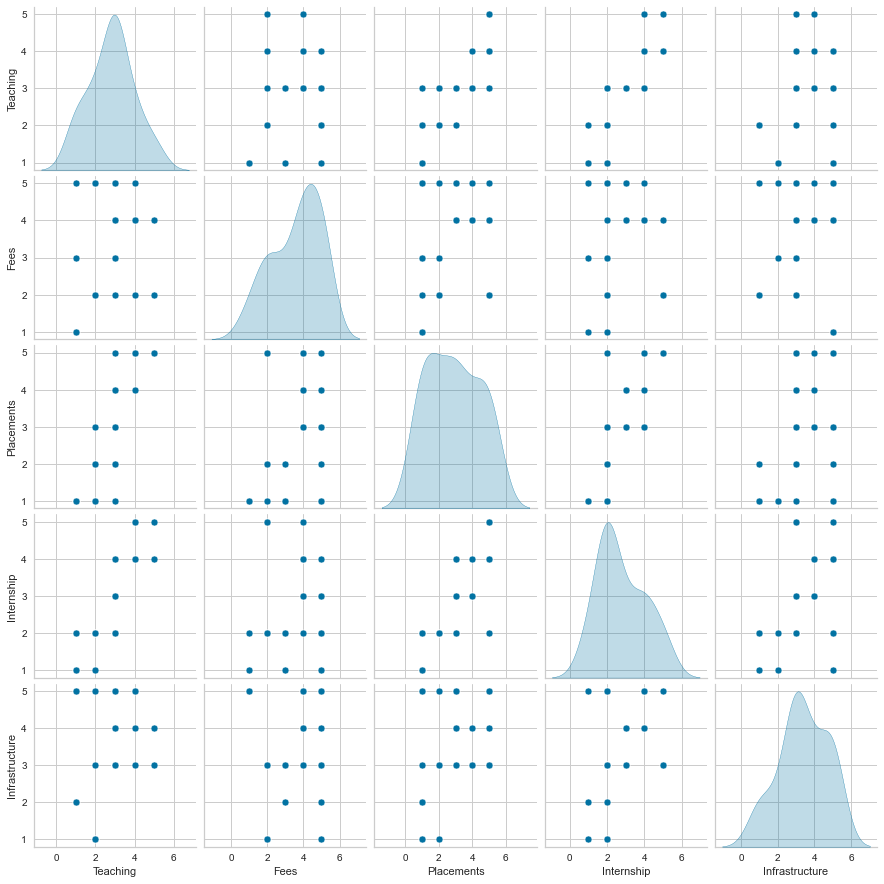

In [13]:
sns.pairplot(df[all_col],diag_kind="kde");

**Observations**
- Teaching is normally distributed
- Distribution of fees seems to be bimodal
- Distribution of Internships seems to be bimodal

In [14]:
# Scaling the data set before clustering
# we are selecting only numerical columns in the data set.
# we will ingore any character column (Engg_College, will be ignored)

scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled=scaler.fit_transform(subset)  

In [15]:
#Creating a dataframe from the scaled data above

subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

In [16]:
subset_scaled_df.head()

# as we see below we scaled al the numercial column and we are not keeping any character column in the data.

,Teaching,Fees,Placements,Internship,Infrastructure
0,1.97,-1.21,1.41,1.83,-0.30
1,1.07,-1.21,1.41,1.83,-0.30
2,1.07,1.09,1.41,1.01,1.27
3,1.97,0.32,1.41,1.01,0.48
4,-0.73,1.09,-0.59,-0.63,1.27


# Kmeans Cluster

Number of Clusters: 1 	Average Distortion: 2.087990295998642
Number of Clusters: 2 	Average Distortion: 1.6030760049686552
Number of Clusters: 3 	Average Distortion: 1.3542868697697457
Number of Clusters: 4 	Average Distortion: 1.1658645562214658
Number of Clusters: 5 	Average Distortion: 1.0290612283501503
Number of Clusters: 6 	Average Distortion: 0.9095886756490557
Number of Clusters: 7 	Average Distortion: 0.8210830918162462
Number of Clusters: 8 	Average Distortion: 0.7161563518185236


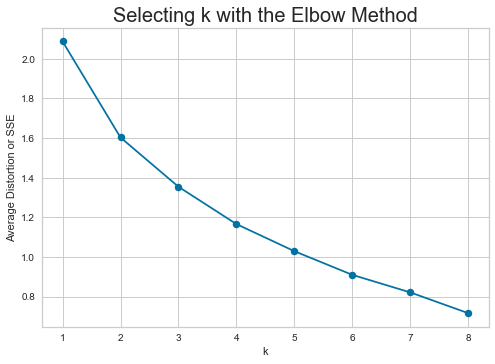

In [17]:
# Perform elbow mehtod to choose the k value.

clusters=range(1,9)
meanDistortions=[]
sse=[] # A list holds the SSE values for each k

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    sse.append(model.inertia_)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions,'.-', markersize=15)
plt.xlabel('k')
plt.ylabel('Average Distortion or SSE')
plt.title('Selecting k with the Elbow Method', fontsize=20);

The appropriate value of k from elbow curve seems to be 4 or 5, we can further confirm which is the appropirate k value using below code.

### Lets us check silhoutte score

In [21]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.3347415593639785)
For n_clusters = 3, silhouette score is 0.2896589939792401)
For n_clusters = 4, silhouette score is 0.3490226771698325)
For n_clusters = 5, silhouette score is 0.3581038185380645)
For n_clusters = 6, silhouette score is 0.3751606440274479)
For n_clusters = 7, silhouette score is 0.3661442615367182)
For n_clusters = 8, silhouette score is 0.3975512934421172)
For n_clusters = 9, silhouette score is 0.39102713851068926)


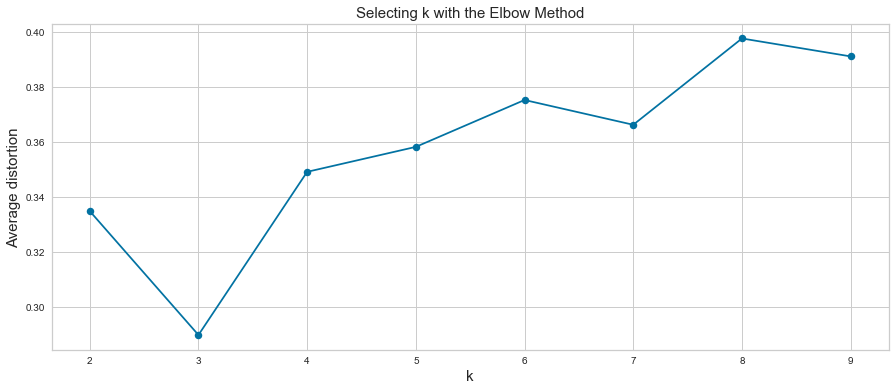

In [22]:
plt.figure(figsize=(15,6))
plt.plot(cluster_list,sil_score, '.-', markersize=15)
plt.xlabel('k').set_fontsize('15')
plt.ylabel('Average distortion').set_fontsize('15')
plt.title('Selecting k with the Elbow Method').set_fontsize('15');

From silhouette score, it seems that 6 is good value of k, after 6 we can see that score dropped.

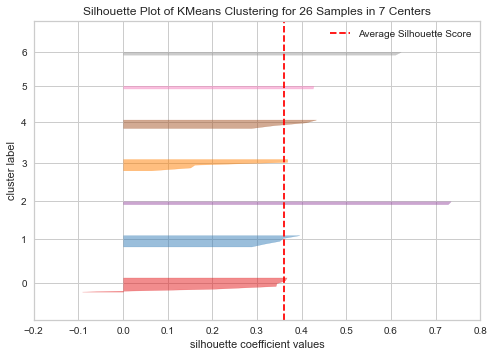

In [23]:
#Finding optimal no. of clusters with silhouette coefficients using K value 7

visualizer = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [24]:
# Silhouette score check for cluster 7.

kmeans_7 = KMeans(n_clusters=7, random_state=1)
kmeans_7.fit(subset_scaled_df)

KMeans(n_clusters=7, random_state=1)

In [25]:
#model evaluation using euclidean

from sklearn import metrics

kmeans_7_score=metrics.silhouette_score(subset_scaled_df, kmeans_7.labels_,
metric='euclidean')
print(kmeans_7_score)

0.3595062293421939


- Silhouette coefficient lies in between -1 and 1. If the value moves towards 1 then clustering is good. If the value moves towards <0 then clustering is bad. We got the Silhouette coefficient value is 0.3595062293421939, lets compare with the kmeans 6.

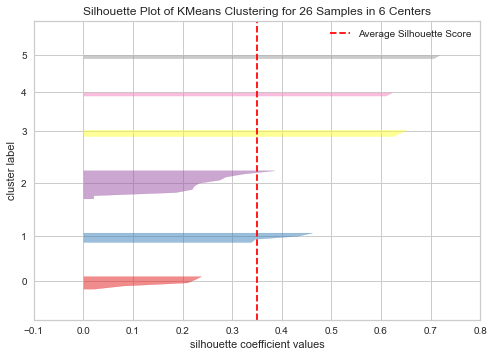

In [26]:
#Finding optimal no. of clusters with silhouette coefficients using K value 6

visualizer = SilhouetteVisualizer(KMeans(6, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [27]:
# Silhouette score check for cluster 6.

kmeans_6 = KMeans(n_clusters=6, random_state=1)
kmeans_6.fit(subset_scaled_df)

KMeans(n_clusters=6, random_state=1)

In [28]:
#model evaluation using euclidean

from sklearn import metrics

kmeans_6_score=metrics.silhouette_score(subset_scaled_df, kmeans_6.labels_,
metric='euclidean')
print(kmeans_6_score)

0.34921395318818566


- Silhouette coefficient lies in between -1 and 1. If the value moves towards 1 then clustering is good. If the value moves towards <0 then clustering is bad. We got the Silhouette coefficient value is 0.34921395318818566, lets compare with the kmeans 5.

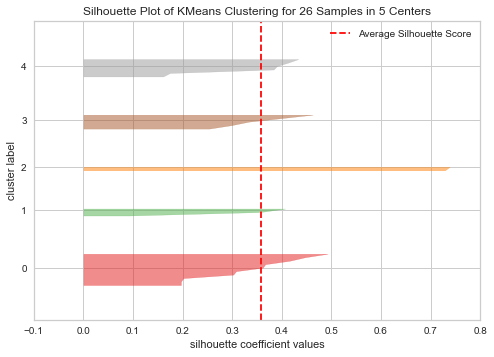

In [29]:
#Finding optimal no. of clusters with silhouette coefficients using K value 5
visualizer = SilhouetteVisualizer(KMeans(5, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [30]:
# Silhouette score check for cluster 5.

kmeans_5 = KMeans(n_clusters=5, random_state=1)
kmeans_5.fit(subset_scaled_df)

KMeans(n_clusters=5, random_state=1)

In [31]:
#model evaluation using euclidean

from sklearn import metrics

kmeans_5_score=metrics.silhouette_score(subset_scaled_df, kmeans_5.labels_,
metric='euclidean')
print(kmeans_5_score)

0.3581038185380645


- Silhouette coefficient lies in between -1 and 1. If the value moves towards 1 then clustering is good. If the value moves towards <0 then clustering is bad. We got the Silhouette coefficient value is 0.3581038185380645, lets compare with the kmeans 4.

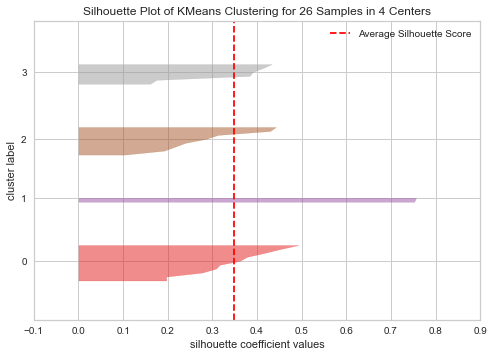

In [32]:
#Finding optimal no. of clusters with silhouette coefficients using K value 5

visualizer = SilhouetteVisualizer(KMeans(4, random_state = 1))
visualizer.fit(subset_scaled_df)    
visualizer.show();

In [33]:
# Silhouette score check for cluster 4.

kmeans_4 = KMeans(n_clusters=4, random_state=1)
kmeans_4.fit(subset_scaled_df)

KMeans(n_clusters=4, random_state=1)

In [34]:
#model evaluation using euclidean

from sklearn import metrics

kmeans_4_score=metrics.silhouette_score(subset_scaled_df, kmeans_4.labels_,
metric='euclidean')
print(kmeans_4_score)

0.3490226771698325


- Silhouette coefficient lies in between -1 and 1. If the value moves towards 1 then clustering is good. If the value moves towards <0 then clustering is bad. We got the Silhouette coefficient value is 0.3490226771698325, lets compare all the scores.

- The Lowest SSE being k value 7.

In [35]:
# print all the different kmeans models silhouette score

print(kmeans_7_score)
print(kmeans_6_score)
print(kmeans_5_score)
print(kmeans_4_score)

0.3595062293421939
0.34921395318818566
0.3581038185380645
0.3490226771698325


- The best silhouette score is for k value 7.

### Let us take 5 as appropriate no. of clusters as silhoutte score is high enough and there is knick at 5 in elbow curve.

In [36]:
df['K_means_segments'] = kmeans_5.labels_
subset_scaled_df['K_means_segments'] = kmeans_5.labels_

In [37]:
cluster_profile = df.groupby('K_means_segments').mean()

In [38]:
cluster_profile['No of Colleges in each Clusters'] = df.groupby('K_means_segments')['Fees'].count().values

In [39]:
cluster_profile

,Teaching,Fees,Placements,Internship,Infrastructure,No of Colleges in each Clusters
K_means_segments,,,,,,
0,2.80,4.50,3.30,2.80,3.80,10
1,1.33,4.33,1.00,1.33,1.67,3
2,1.00,1.00,1.00,1.50,5.00,2
3,2.60,2.40,1.60,2.00,2.20,5
4,4.33,3.50,4.83,4.50,4.00,6


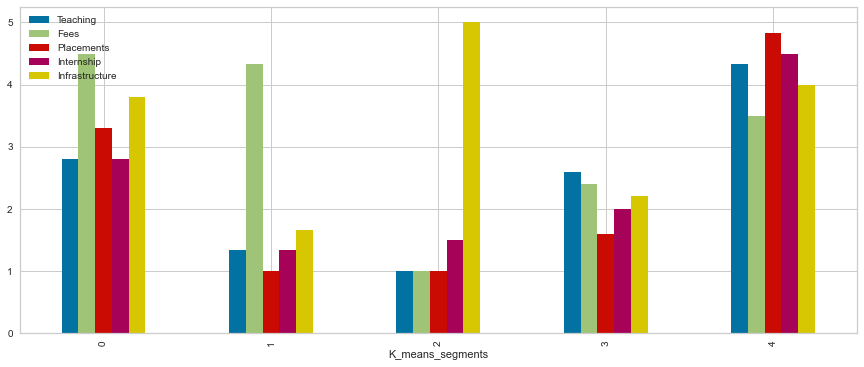

In [40]:
df.groupby('K_means_segments').mean().plot.bar(figsize=(15,6));

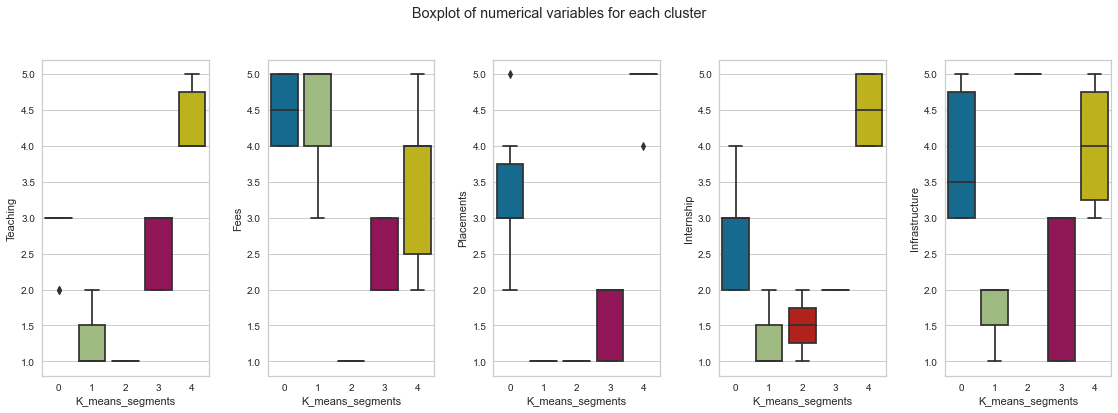

In [41]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Insights**
- Clusters 0 :
    - Teaching rating is around 3 for majority of its colleges
    - Fees is very high of colleges in this cluster
    - Placements rating is spread over rating from 2 to 5 
    - Internship is medium
    - Infrastructure is medium to high
- Cluster 1 :
    - Teaching is medium to high for majority of colleges in this cluster
    - Fess is high
    - Placements is medium to very high
    - Internship is high
    - Infrastructure is high to very high for majority of colleges in this cluster
- Cluster 2 :
    - Teaching is very low to medium
    - Fee is low to very high
    - Placements is very low
    - Internship is low
    - Infrastructure is also low
- Cluster 3:
    - Teaching is high to very for majority of colleges in this cluster
    - Fee is low
    - Placements is very high
    - Internship is very high
    - Infrastructure is medium

- Cluster 4:
    - Teaching is very low
    - Fees is very low
    - Placements is very low
    - Internship is low
    - Infrastructure is very high
    

### Business recommendation
- Cluster 3 (Tier 1 Colleges) - have excellent teaching, placements & 
  internships while Infrastructure and fees are at satisfactory levels.
   - **Recommendation - Corporates looking for best candidates can approach this cluster for placements and internships**
- Cluster 0 (Tier 2 Colleges) - Medium performing colleges with high fees
   - **Recommendation - Scope for Improvements in Teaching, Placements and internships - Tie-ups with corporates, Edu-tech and training entities. Companies providing training program to staffs and students should approach them.**

- Cluster 2 (Tier 3 Colleges) - Poor performing colleges/new college
   - **Recommendation - These cluster of colleges Will need to concentrate more on Marketing and Advertisements about their campus to create awareness and attract students.**

### Business Recommendation

- **Cluster 3**: These are the Tier 1 Colleges and have excellent teaching, placements & internships, while maintaining a moderate infrastructure and low fees. **Corporates looking for best candidates can approach this cluster for placements and internships.**

- **Cluster 1**: These are the Tier 2 Colleges which are just behind the Tier 1 colleges in terms of teaching and placements, but provide quite better infrastructure and are accordingly more expensive. **They have a scope for improvements in teaching, placements and internships, and should consider tie-ups with corporates, edu-tech and training organizations. Companies providing training program to faculty and students should approach them.**

- **Cluster 0**: These are the Tier 3 colleges which have high fees and good infrastructure, but do not offer proper value-for-money in terms of teaching and placements. **These cluster of colleges will need to concentrate more towards onboarding better faculty and securing tie-ups with corporates to improve placement opportunities.**

- **Cluster 2 and Cluster 4**: These are the poor performing colleges or new colleges. **These colleges will need to concentrate more on marketing and advertisements about their offerings to create awareness and attract students.**

In [42]:
#view the data with  the new cluster columns (K_means_segments)

df.head()

,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure,K_means_segments
0,A,5,2,5,5,3,4
1,B,4,2,5,5,3,4
2,C,4,5,5,4,5,4
3,D,5,4,5,4,4,4
4,E,2,5,2,2,5,0


-----------

# Hierarchical Clustering

In [43]:
# make a copy of the data.

df=data.copy()

In [44]:
#dropping the serial no. column as it does not hold any statistical significance

df.drop('SR_NO',axis=1,inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Internship      26 non-null     int64 
 5   Infrastructure  26 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


In [46]:
# Scaling the data set before clustering
# we are selecting only numerical columns in the data set.
# we will ingore any character column (Engg_College, will be ignored)
scaler=StandardScaler()
subset=df[all_col].copy()
subset_scaled=scaler.fit_transform(subset)  

In [47]:
#Creating a dataframe from the scaled data above

subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

In [48]:
subset_scaled_df.head()

# as we see below we scaled al the numercial column and we are not keeping any character column in the data.

,Teaching,Fees,Placements,Internship,Infrastructure
0,1.97,-1.21,1.41,1.83,-0.30
1,1.07,-1.21,1.41,1.83,-0.30
2,1.07,1.09,1.41,1.01,1.27
3,1.97,0.32,1.41,1.01,0.48
4,-0.73,1.09,-0.59,-0.63,1.27


In [49]:
# Finding the Highest cophenet correlation using different distance metrics and linkage method.

# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

distance_metrics = ['euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
        print('Cophenetic correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for distance metrics euclidean and linkage method single is 0.6703610040291093
Cophenetic correlation for distance metrics euclidean and linkage method complete is 0.6811135884618835
Cophenetic correlation for distance metrics euclidean and linkage method average is 0.7249608173132106
Cophenetic correlation for distance metrics euclidean and linkage method weighted is 0.718947054154437
Cophenetic correlation for distance metrics chebyshev and linkage method single is 0.664902620846343
Cophenetic correlation for distance metrics chebyshev and linkage method complete is 0.709585154345703
Cophenetic correlation for distance metrics chebyshev and linkage method average is 0.7293593042072495
Cophenetic correlation for distance metrics chebyshev and linkage method weighted is 0.7058899238448005
Cophenetic correlation for distance metrics mahalanobis and linkage method single is 0.5144747975408697
Cophenetic correlation for distance metrics mahalanobis and linkage metho

In [50]:
print('Highest Cophenetic correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.
      format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest Cophenetic correlation is 0.7293593042072495, which is obtinaed with chebyshev distance metric and average linkage method


In [51]:
'''
Note: We cannot use ward, median and centroid on 'chebyshev','mahalanobis','cityblock' metrics, it has to be only
on Euclidean distance metrics. Therefore, in the below we will use Distance Metrics as Euclidean
and then use available linkage methods ['single', 'complete', 'average','median','ward', 'weighted','centroid']
on Euclidean distance metrics.
'''
# Lets explore 'centroid', 'median','ward' linkage method which requires only Euclidean distance metrics

linkage_methods = ['single', 'complete', 'average','median','ward', 'weighted','centroid']
high_cophenet_corr = 0
high_dm_lm = [0,0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric='euclidean', method=lm)
    c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
    print('Cophenetic correlation for distance metrics {} and linkage method {} is {}'.format('euclidean',lm,c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = dm
        high_dm_lm[1] = lm
print('*'*110)
print('Highest Cophenetic correlation is {}, which is obtinaed with {} distance metric'.
      format(high_cophenet_corr ,high_dm_lm[1]))

Cophenetic correlation for distance metrics euclidean and linkage method single is 0.6703610040291093
Cophenetic correlation for distance metrics euclidean and linkage method complete is 0.6811135884618835
Cophenetic correlation for distance metrics euclidean and linkage method average is 0.7249608173132106
Cophenetic correlation for distance metrics euclidean and linkage method median is 0.6315922162683684
Cophenetic correlation for distance metrics euclidean and linkage method ward is 0.6810415934130346
Cophenetic correlation for distance metrics euclidean and linkage method weighted is 0.718947054154437
Cophenetic correlation for distance metrics euclidean and linkage method centroid is 0.7347475920075069
**************************************************************************************************************
Highest Cophenetic correlation is 0.7347475920075069, which is obtinaed with centroid distance metric


- When we compare both the above metrics, we see that centroid distance metric produced good score of 0.734.
- To select which metrics and linkage method are good for the model building we use the Cophenetic Correlation score. We take the score which produces the highest Cophenetic correlation, as we see above, euclidean linkage method centroid produced score of 73.47%. However, the Cophenetic Correlation score is not the only choice of metrics, we refer to dendrogram to identify the number of clusters and to visualize how each linkage method produces distinct and separate clusters and then we choose the optimal linkage method.

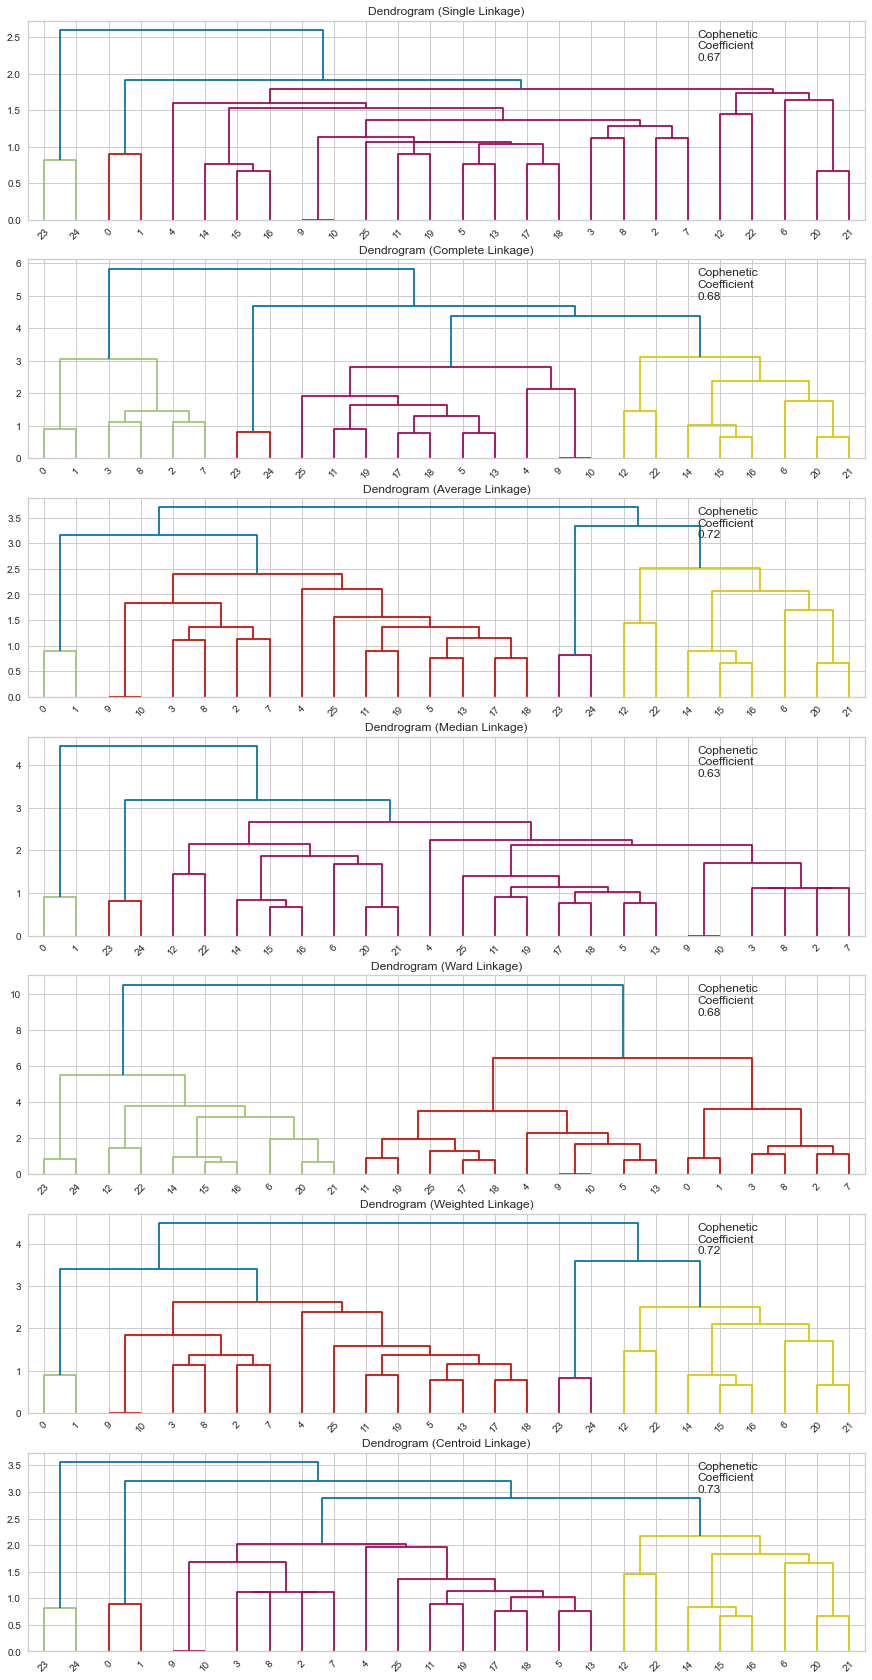

In [52]:
# List of all linkage methods to check

methods = ['single', 'complete', 'average','median','ward', 'weighted','centroid']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

In [53]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage

df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc.sort_values(by='Cophenetic Coefficient',ascending=False)

,Linkage,Cophenetic Coefficient
6,centroid,0.73
2,average,0.72
5,weighted,0.72
1,complete,0.68
4,ward,0.68
0,single,0.67
3,median,0.63


- We see that Centroid is having highest Cophenetic Coefficient, follwed by average. Least being median.
- As we see from the above dendrograms that COMPLETE and WARD are very distinctive and clusters are separable. COMPLETE linkage is more differentiable than WARD linkage with 4 clusters.
- To choose the number of clusters first we investigate the X-axis contains the samples and the Y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line and hence we can decide on a threshold of 40 and cut the dendrogram. We have 4 clusters as this line cuts the dendrogram at three points. This is how we choose the number of clusters from the Dendrogram chart for Hierarchal clustering.

In [54]:
# Building Hierarchical clustering model with K value 4 using COMPLETE Linkage.

HCmodel = AgglomerativeClustering(n_clusters=4,affinity='euclidean', linkage='complete')
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [55]:
# assign the model labels to a new variable for original data set and also working file.

df['HC_Clusters'] = HCmodel.labels_ # this is for our insight and analysis

In [56]:
#Bar plots of categorical features
for feature in df.dtypes[df.dtypes == 'category'].index:
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index)
    plt.show()

In [57]:
# Function to create barplots that indicate percentage for each category.

def bar_perc(plot, feature,font_size):
    '''
    plot
    feature: 1-d categorical feature array
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = font_size) # annotate the percantage

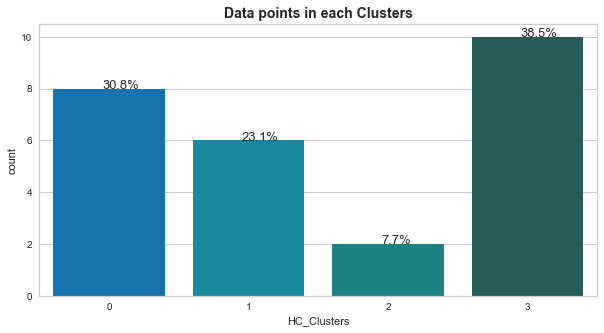

In [58]:
# data points in each clusters.

plt.figure(figsize=(10,5))
ax=sns.countplot(x='HC_Clusters',data=df,palette='winter_d');
plt.title('Data points in each Clusters', weight='bold').set_fontsize('14')
bar_perc(ax,df['HC_Clusters'],font_size=13)

- From the COMPLETE Linkage method we can see that Cluster 0 contains 30.8% of the data points, Cluster 1 contains 23.1% of the data points, Cluster 2 contains 7.7% of the data points and cluster 3 with 38.5% of the data points

In [59]:
# create an object and assign the group by of HC_Clusters using mean value of entire numerical columsn

cluster_profile_HCC = df.groupby('HC_Clusters').mean().round(decimals=2)
cluster_profile_HCC

,Teaching,Fees,Placements,Internship,Infrastructure
HC_Clusters,,,,,
0,2.12,3.12,1.38,1.75,2.00
1,4.33,3.50,4.83,4.50,4.00
2,1.00,1.00,1.00,1.50,5.00
3,2.80,4.50,3.30,2.80,3.80


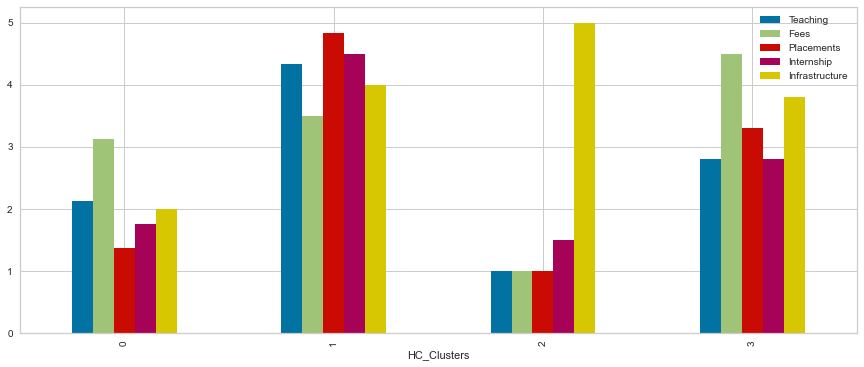

In [60]:
df.groupby('HC_Clusters').mean().plot.bar(figsize=(15,6));

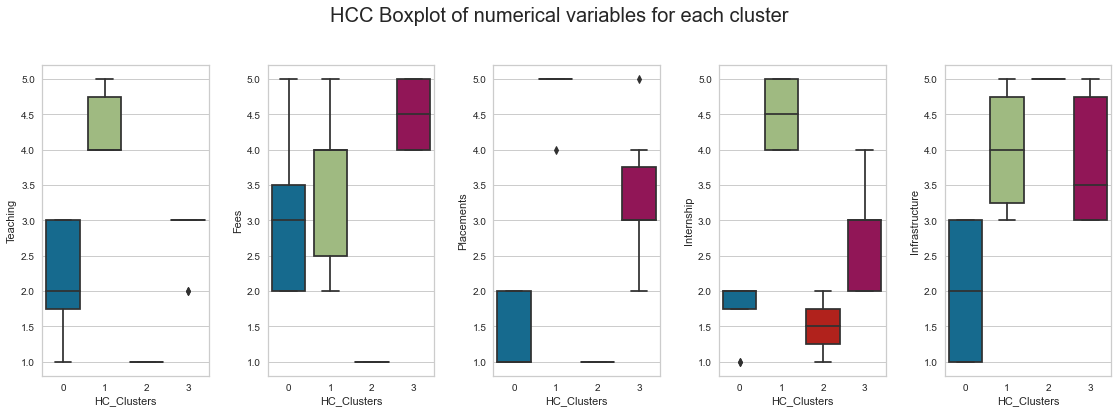

In [61]:
# create a box plot chart for visualization purpose and anlyze how each clusters represents

fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('HCC Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df[all_col[counter]],x=df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

In [62]:
#view the data with  the new cluster columns
df.head()

,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure,HC_Clusters
0,A,5,2,5,5,3,1
1,B,4,2,5,5,3,1
2,C,4,5,5,4,5,1
3,D,5,4,5,4,4,1
4,E,2,5,2,2,5,3


**Insights**
- Clusters 0 :
    - Teaching rating is around 3 for majority of its colleges
    - Fees is very high of colleges in this cluster
    - Placements rating is very low just 2
    - Internship is low.
    - Infrastructure is very low.
        
- Clusters 1 :
    - Teaching rating is highest
    - Fees is very high of colleges in this cluster
    - Placements rating is also high.
    - Internship is high.
    - Infrastructure is also high.    

- Clusters 2 :
    - Teaching rating is lowest among the clusters.
    - Fees is also lowest among the clusters.
    - Placements is also having lowest among the clusters.
    - Internship is low, same as cluster 0.
    - Infrastructure is pretty high.
    
    
- Clusters 3 :
    - Teaching rating is average
    - Fees is high
    - Placements is second highest.
    - Internship is medium
    - Infrastructure is pretty high.

- **Business Recommendation is made only to Kmeans Clustering due to time constraints.**

---------